In [64]:
!pip install contractions
!pip install pyLDAvis
!pip install matplotlib
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
import pandas as pd

df = pd.read_json('all_posts_TillSverige.json', 'values')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       932 non-null    object
dtypes: object(1)
memory usage: 7.4+ KB


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-65-91f5d91f3051>:3: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  df = pd.read_json('all_posts_TillSverige.json', 'values')


In [66]:
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,A fence for a dog Hi! I would like to fence a ...
1,"Moving to Sweden from Georgia Hej, everyone!\..."
2,Can you register for a personnummer… in a city...
3,What stores would sell bathrobes for men? I kn...
4,SL card or ticket on your phone Can someone he...


## Text pre-processing


In [69]:
import nltk
import re
import numpy as np
import contractions
from nltk.stem import PorterStemmer
ps = PorterStemmer()

stop_words = set(nltk.corpus.stopwords.words('english'))

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # stemming 
    stemmed_tokens = [ps.stem(token) for token in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(stemmed_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df[0].transpose()))
clean_text = [
     [word for word in document.split(' ') if word.isdigit()==False]
     for document in norm_corpus
]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topics Modeling


In [70]:
from gensim.models import CoherenceModel

def getCoherenceScore(model):
  coh_model_bw = CoherenceModel(model = model,
                                  texts = clean_text,
                                  dictionary = dictionary,
                                  coherence = 'c_v'
                                 )
  return coh_model_bw.get_coherence()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
from gensim import corpora
dictionary = corpora.Dictionary(clean_text)
corpus = [dictionary.doc2bow(text) for text in clean_text]

from gensim import models

tfidf_model = models.TfidfModel(corpus)  
tfidf = tfidf_model[corpus]


ldaModels = []
ldaMultModels = []
lsiModels = []

ldaCohScores = []
ldaMultCohScores = []
lsiCohScores = []
topics = [2,3,4,5,6,7,8,9,10]
iterations = 100
passes = 20
random_state = 7

for topicsNum in topics:
  ldaModels.append(models.LdaModel(tfidf, id2word=dictionary, num_topics=topicsNum, random_state=random_state, iterations=iterations, passes=passes))
  ldaMultModels.append(models.LdaMulticore(tfidf, num_topics=topicsNum, random_state=random_state, id2word=dictionary, iterations=iterations, passes=passes))
  lsiModels.append(models.LsiModel(tfidf, id2word=dictionary, num_topics=topicsNum, random_seed=random_state ))
  ldaCohScores.append(getCoherenceScore(ldaModels[topicsNum - 2]))
  ldaMultCohScores.append(getCoherenceScore(ldaMultModels[topicsNum - 2]))
  lsiCohScores.append(getCoherenceScore(lsiModels[topicsNum - 2]))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools`

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


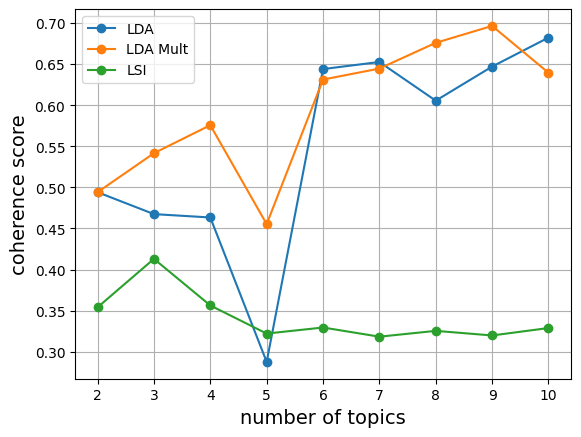

In [74]:

import matplotlib.pyplot as plt
   
plt.plot(topics, ldaCohScores, label = "LDA", marker='o')
plt.plot(topics, ldaMultCohScores, label = "LDA Mult", marker='o')
plt.plot(topics, lsiCohScores, label = "LSI", marker='o')
plt.xlabel('number of topics', fontsize=14)
plt.ylabel('coherence score', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [76]:
bestModel = ldaMultModels[7]
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(bestModel, corpus, dictionary=bestModel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.252126 -0.001319       1        1  84.813508
7      0.025446  0.048182       2        1   3.692324
0      0.035404 -0.013260       3        1   2.136993
2      0.034267 -0.009555       4        1   1.985227
3      0.033329 -0.007199       5        1   1.672428
8      0.032720 -0.005664       6        1   1.662441
1      0.032352 -0.003469       7        1   1.505355
6      0.030740 -0.003179       8        1   1.317168
4      0.027868 -0.004538       9        1   1.214557, topic_info=         Term       Freq      Total Category  logprob  loglift
870    electr  34.000000  34.000000  Default  30.0000  30.0000
500      cost  47.000000  47.000000  Default  29.0000  29.0000
149      sell  47.000000  47.000000  Default  28.0000  28.0000
492      area  47.000000  47.000000  Default  27.0000  27.0000
430    specif  50.000000  50.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
2121  trailer   0.701141   6.165918   Topic9  -6.8722   2.2367
3406     bind   0.768930   9.438741   Topic9  -6.7800   1.9032
1598  ireland   0.644112   5.173708   Topic9  -6.9571   2.3273
1704   suppos   0.629263   6.211997   Topic9  -6.9804   2.1211
975       box   0.580406  16.984787   Topic9  -7.0612   1.0344

[417 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1462      1  0.214710      1st
1462      2  0.214710      1st
1462      5  0.214710      1st
666       1  0.320902       2k
666       7  0.320902       2k
...     ...       ...      ...
1657      1  0.267031   youtub
1657      3  0.267031   youtub
1657      9  0.267031   youtub
3794      1  0.321711  zeeland
3794      5  0.321711  zeeland

[920 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 1, 3, 4, 9, 2, 7, 5])

In [77]:
print(ldaModels[7])

LdaModel<num_terms=5293, num_topics=9, decay=0.5, chunksize=2000>


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
